# freecodecamp - Cat and Dog Image Classifier -


<div class="alert alert-block alert-info">
<b>freecodecamp:</b><br>
For this challenge, you will complete the code to classify images of dogs and cats. You will use TensorFlow 2.0 and Keras to create a convolutional neural network that correctly classifies images of cats and dogs at least 63% of the time. (Extra credit if you get it to 70% accuracy!)
</div>

> The first code cell imports the required libraries.

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

2023-09-20 16:30:05.041700: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 16:30:06.027178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


> The second code cell downloads the data and sets key variables.

In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

> The structure of the dataset files that are downloaded looks like this (You will notice that the test directory has no subdirectories and the images are not labeled): 

>     cats_and_dogs
>     |__ train:
>         |______ cats: [cat.0.jpg, cat.1.jpg ...]
>         |______ dogs: [dog.0.jpg, dog.1.jpg ...]
>     |__ validation:
>         |______ cats: [cat.2000.jpg, cat.2001.jpg ...]
>         |______ dogs: [dog.2000.jpg, dog.2001.jpg ...]
>     |__ test: [1.jpg, 2.jpg ...]

> You can tweak epochs and batch size if you like, but it is not required.

<div class="alert alert-block alert-info">
<b>Tip:</b> After the *.zip file is downloaded and unpacked, commend these two lines on:<br>
<code>!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip</code> <br>and <br>
<code>!unzip cats_and_dogs.zip</code><br>to avoid downloading again.
</div>

> The third cell is the first place you will write your own code.
> The following instructions correspond to specific cell numbers, indicated with a comment at the top of the cell (such as # 3).

### Cell 3

> Now it is your turn! Set each of the variables in this cell correctly. (They should no longer equal None.)<br><br> Create image generators for each of the three image data sets (train, validation, test). Use ImageDataGenerator to read / decode the images and convert them into floating point tensors. Use the rescale argument (and no other arguments for now) to rescale the tensors from values between 0 and 255 to values between 0 and 1.<br><br> For the *_data_gen variables, use the flow_from_directory method. Pass in the batch size, directory, target size ((IMG_HEIGHT, IMG_WIDTH)), class mode, and anything else required. test_data_gen will be the trickiest one. For test_data_gen, make sure to pass in shuffle=False to the flow_from_directory method. This will make sure the final predictions stay is in the order that our test expects. For test_data_gen it will also be helpful to observe the directory structure.<br><br>After you run the code, the output should look like this:
>
>     Found 2000 images belonging to 2 classes.
>     Found 1000 images belonging to 2 classes.
>     Found 50 images belonging to 1 class.

In [3]:
# 3
seed = 1207
tf.keras.utils.set_random_seed(seed)
scale = 1.0 / 255.0

train_image_generator = ImageDataGenerator(rescale=scale)
validation_image_generator = ImageDataGenerator(rescale=scale)
test_image_generator = ImageDataGenerator(rescale=scale)

train_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           batch_size=batch_size,
                                                           seed=seed
                                                          )
val_data_gen = validation_image_generator.flow_from_directory(directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary',
                                                              batch_size=batch_size,
                                                              seed=seed
                                                             )
test_data_gen = test_image_generator.flow_from_directory(directory=test_dir,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         classes=["."],
                                                         batch_size=batch_size,
                                                         seed=seed,
                                                         shuffle=False)  # see explanation below 

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


<div class="alert alert-block alert-success">
<b>Up to you:</b> Depending on your tensorflow version, the freecodecamp procedure is not anymore up to date. Please check <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#methods">ImageDataGenerator</a>:<br>Deprecated: <u>tf.keras.preprocessing.image.ImageDataGenerator</u> is <b>not recommended</b> for new code. <b>Prefer</b> loading images with <u>tf.keras.utils.image_dataset_from_directory</u> and <I>transforming the output tf.data.Dataset with preprocessing layers</I>. For more information, see the tutorials for loading images and augmenting images, as well as the preprocessing layer guide.
</div>

For <code>test_data_gen</code> we must additionally define the classes argument. This is because the <code>*.flow_from_directory</code> aassumes a directory structure like the one mentioned above: a directory with two or more subdirectories, where the list of classes is automatically derived from the names/structures of the subdirectories under the directory, treating each subdirectory as a different class, see __[ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#methods)__.

### Cell 4

> The <code>plotImages</code> function will be used a few times to plot images. It takes an array of images and a probabilities list, although the probabilities list is optional. <b>This code is given to you</b>. If you created the <code>train_data_gen</code> variable correctly, then running this cell will plot five random training images.

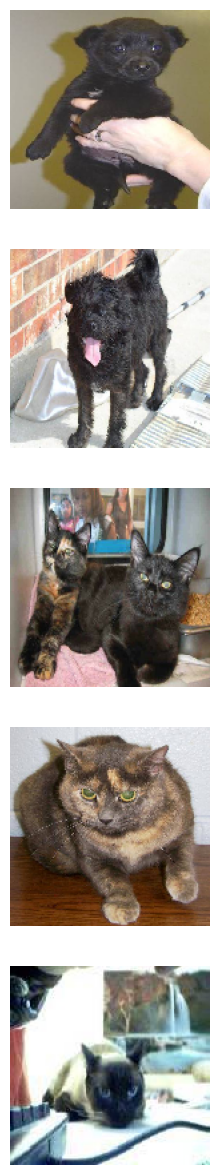

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

### Cell 5

> Recreate the train_image_generator using ImageDataGenerator.<br><br>Since there are a small number of training examples, there is a risk of overfitting. One way to fix this problem is by creating more training data from existing training examples by using random transformations.<br><br>Add 4-6 random transformations as arguments to ImageDataGenerator. Make sure to rescale the same as before.

In [5]:
# 5
train_image_generator = ImageDataGenerator(rotation_range=54,
                                           width_shift_range=0.15,
                                           height_shift_range=0.15,
                                           shear_range=0.15,
                                           zoom_range=0.15,
                                           horizontal_flip=True,  # -
                                           # vertical_flip=True,  # |
                                           validation_split=.2,
                                           rescale=scale,  # 1. / 255.
                                          )

Image Data Augmentation is a technique that can artificially increase the size of a training dataset by creating modified versions of the images in the dataset.<br>Training Convolutional Neural Network models on more data can lead to better models, and augmentation techniques can create variations of the images that improve the ability of the adapted models to generalize what they have learned to new images. Furthermore, Data augmentation can also serve as a regularization technique, adding noise to the training data and encouraging the model to learn the same features regardless of their position in the input.<br>Small changes to the input photos of dogs and cats could be useful for this problem, such as small shifts and horizontal rotations. These extensions can be specified as arguments to the ImageDataGenerator used for the training dataset. The extensions should not be used for the test dataset because we want to evaluate the performance of the model using the unmodified photos.<br><br>In this case, the images in the training dataset will be augmented with small (20%) random rotation, horizontal and vertical shifts as well as a random shear and zoom. In addition, we allow horizontal flip that create a mirror image of the original.

<div class="alert alert-block alert-info">
<b>Tip:</b> Data Augmentation does what?<br>While the word “augment” means to make something “greater” or “increase” something (in this case, data), the Keras ImageDataGenerator class actually works by:

- Accepting a batch of images used for training.
- Taking this batch and applying a series of random transformations to each image in the batch (including random rotation, resizing, shearing, etc.).
- Replacing the original batch with the new, randomly transformed batch.
- Training the CNN on this randomly transformed batch (i.e., the original data itself is not used for training).

That’s right — the Keras ImageDataGenerator class is not an “additive” operation. It’s not taking the original data, randomly transforming it, and then returning both the original data and transformed data. Instead, <u><b>the ImageDataGenerator accepts the original data, randomly transforms it, and returns only the new, transformed data</u></b> -> This is also called <b>in-place/on-the-fly</b> data augmentation
</div>

### Cell 6

> You don't have to do anything for this cell. <code>train_data_gen</code> is created just like before but with the new train_image_generator. Then, a single image is plotted five different times using different variations.

Found 2000 images belonging to 2 classes.


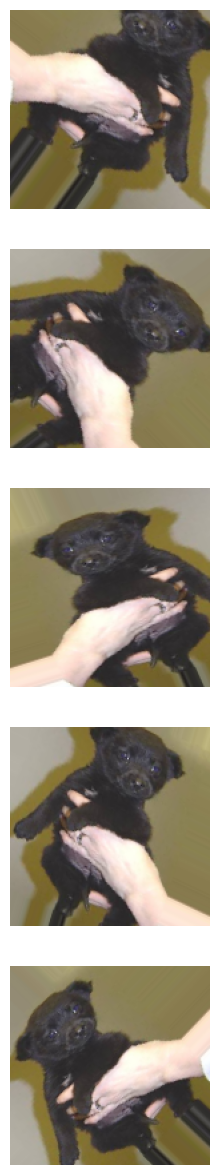

In [6]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           seed=seed)

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

### Cell 7

> In this cell, create a model for the neural network that outputs class probabilities. It should use the Keras Sequential model. It will probably involve a stack of Conv2D and MaxPooling2D layers and then a <u>fully connected layer on top that is activated by a ReLU activation function</u>.
>
> Compile the model passing the arguments to set the optimizer and loss. Also pass in <code>metrics=['accuracy']</code> to view training and validation accuracy for each training epoch.

<div class="alert alert-block alert-info">
<b>Tip:</b> Building the model<br><br>Since we are dealing with large images and a more complex problem, the model must be larger accordingly. This is partly to increase the capacity of the model, and partly to further reduce the size of the feature maps. The goal is to reduce the size of the feature maps as much as possible before reaching the "flatten" layer.<br><br>The problem of classifying cat and dog images is binary (either or). Therefore, we are dealing with a <I>binary classification</I> problem, so the model should end with a single unit (<I>a dense layer of size 1</I>) and a <I>sigmoid</I> activation function. This unit encodes the probability that the model considers one class or the other.<br><br>One way to reduce overfitting is to add a dropout layer to our model just before the densely linked classifier.
</div>

In [8]:
# 7
model = Sequential()
# Input layer
model.add(Conv2D(filters=32,
                 kernel_size=(3, 3),
                 activation="relu",
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
                ))
model.add(MaxPooling2D((2, 2)))
# First layer
model.add(Conv2D(filters=64,
                 kernel_size=(3, 3),
                 activation="relu"
                ))
model.add(MaxPooling2D((2, 2)))
# Second layer
model.add(Conv2D(filters=128,
                 kernel_size=(3, 3),
                 activation="relu"
                ))
model.add(MaxPooling2D((2, 2)))
# Third layer
model.add(Conv2D(filters=256,
                 kernel_size=(3, 3),
                 activation="relu"
                ))
model.add(MaxPooling2D((2, 2)))
# Flatten layer
model.add(Flatten())
# Dropout layer
model.add(Dropout(0.5))
# Dense Layer
#model.add(Dense(128, activation='relu'))
# Output layer (classifier)
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='binary_crossentropy',  # tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
             )

model.summary()

2023-09-20 16:30:13.159173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-20 16:30:13.214141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-20 16:30:13.214424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

### Cell 8

> Use the fit method on your model to train the network. Make sure to pass in arguments for <code>x</code>, <code>steps_per_epoch</code>, <code>epochs</code>, <code>validation_data</code>, and <code>validation_steps</code>.

Where <code>x</code> represents the training data generated in cell 6, <code>steps_per_epoch</code> can be calculated by dividing the total training data by the batch size, and the <code>validation_steps</code> are the total validation data per batch size.

In [9]:
# 8
steps_per_epoch = np.ceil(total_train / batch_size)
print("Steps per epoch:", steps_per_epoch)
validation_steps = np.ceil(total_val / batch_size)
print("Validation steps:", validation_steps)

history = model.fit(x=train_data_gen,
                    epochs=epochs,
                    validation_data=val_data_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                   )

Steps per epoch: 16.0
Validation steps: 8.0
Epoch 1/15


2023-09-20 16:30:17.469781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-09-20 16:30:20.570770: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdb7c264380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-20 16:30:20.570810: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 850M, Compute Capability 5.0
2023-09-20 16:30:20.578750: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-20 16:30:20.937393: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 [==============================] - 42s 2s/step - loss: 0.6962 - accuracy: 0.4980 - val_loss: 0.6895 - val_accuracy: 0.5000
Epoch 2/15
16/16 [==============================] - 36s 2s/step - loss: 0.6881 - accuracy: 0.5380 - val_loss: 0.6828 - val_accuracy: 0.6080
Epoch 3/15
16/16 [==============================] - 27s 2s/step - loss: 0.6779 - accuracy: 0.5455 - val_loss: 0.6578 - val_accuracy: 0.5930
Epoch 4/15
16/16 [==============================] - 37s 2s/step - loss: 0.6569 - accuracy: 0.5950 - val_loss: 0.6349 - val_accuracy: 0.6540
Epoch 5/15
16/16 [==============================] - 37s 2s/step - loss: 0.6323 - accuracy: 0.6310 - val_loss: 0.6013 - val_accuracy: 0.6580
Epoch 6/15
16/16 [==============================] - 31s 2s/step - loss: 0.6166 - accuracy: 0.6525 - val_loss: 0.5853 - val_accuracy: 0.6990
Epoch 7/15
16/16 [==============================] - 29s 2s/step - loss: 0.5990 - accuracy: 0.6720 - val_loss: 0.5998 - val_accuracy: 0.6690
Epoch 8/15
16/16 [=============

### Cell 9

> Run this cell to visualize the accuracy and loss of the model.

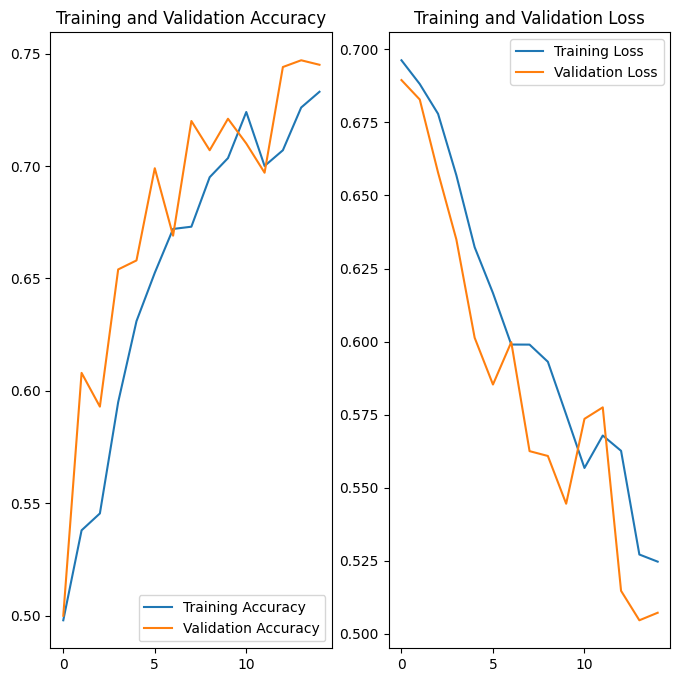

In [10]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that the training and validation curves are relatively close (acceptable correlation), so overfitting is not expected. There is a possibility that we have not yet learned all the relevant patterns with our model, as both the accuracy and losses indicate that they increase and decrease, respectively, with further epochs. However, according to fcc, it is not necessary to change the number of epochs, so we are content with that for now.

### Cell 10

> Now it is time to use your model to predict whether a brand new image is a cat or a dog.<br><br>In this cell, get the probability that each test image (from test_data_gen) is a dog or a cat. probabilities should be a list of integers.<br><br>Call the plotImages function and pass in the test images and the probabilities corresponding to each test image.<br><br>After you run the cell, you should see all 50 test images with a label showing the percentage of "sure" that the image is a cat or a dog. The accuracy will correspond to the accuracy shown in the graph above (after running the previous cell). More training images could lead to a higher accuracy.

1/1 [==============================] - 2s 2s/step


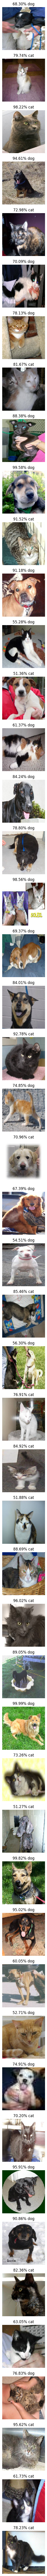

In [11]:
test_images, _ = next(test_data_gen)
probabilities = model.predict(test_data_gen)
plotImages(test_images, probabilities=probabilities)

### Cell 11

> Run this final cell to see if you passed the challenge or if you need to keep trying.

In [12]:
probabilities = probabilities.reshape(-1)  # to avoid dtype error within round(probability)
probabilities.round()

array([1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

In [13]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 76.0% of the images of cats and dogs.
You passed the challenge!


Done! The model correctly classifies more than 63 percent of the images (more precisely 76% exactly).<br><br>We can improve our model by tweaking the layers and/or the filters, but the best improvement for our model would be by increasing the size of the data set. Adjusting the model optimizer as well as the loss function is not expected to have a significant impact on our result.

A better option is to save the augmented images additionally or search the internet for more available resources.

One code snippet to save the augmented pictures is this:

```Python
# construct the image generator for data augmentation then
# initialize the total number of images generated thus far
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
total = 0

# Next, we’ll construct a Python generator and put it to work until all of our images have been produced:
print("[INFO] generating images...")
imageGen = aug.flow(image, batch_size=1, save_to_dir=args["output"],
	save_prefix="image", save_format="jpg")
# We will use the imageGen to randomly transform the input image (Lines 39 and 40). This generator saves images as .jpg files to the specified output directory contained within args["output"].

# Finally, we’ll loop over examples from our image data generator and count them until we’ve reached the required total number of images.
for image in imageGen:
	# increment our counter
	total += 1
	# if we have reached the specified number of examples, break
	# from the loop
	if total == args["total"]:
		break
```

https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/